# Veterinary Business Intelligence System - ETL Pipeline (Task 2)

This notebook implements the Data Requirement, System Design & Development phase of the project.
It covers:
1.  **Data Extraction**: Fetching data from FDA API, Dog API, and a supplementary CSV source.
2.  **Staging**: Loading raw data into a staging environment (Pandas DataFrames).
3.  **Transformation**: Cleaning, normalizing, and enriching the data.
4.  **Data Warehousing**: Designing and populating a Star Schema in a local SQLite database.
5.  **Validation**: Running queries to ensure data quality and business relevance.

# 1. Setup and Library Imports


In [65]:
# 1. Setup and Library Imports
import pandas as pd
import numpy as np
import requests
import sqlite3
import json
import os
from datetime import datetime, timedelta
import time

# Configuration
DATA_DIR = '../data'
RAW_DIR = os.path.join(DATA_DIR, 'raw')
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
DB_PATH = os.path.join(DATA_DIR, 'veterinary_dw.db')

# Ensure directories exist
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

print("Libraries imported and directories setup.")

Libraries imported and directories setup.


# 2. Data Extraction: FDA Adverse Event API


In [66]:
# 2. Data Extraction: FDA Adverse Event API

def fetch_fda_data(max_records_to_fetch, limit=500, api_key=None):

    base_url = "https://api.fda.gov/animalandveterinary/event.json"

    # Query for the last 15 years (approximate start date)
    start_date = (datetime.now() - timedelta(days=15*365)).strftime('%Y%m%d')
    end_date = datetime.now().strftime('%Y%m%d')

    params = {
        'search': f'original_receive_date:[{start_date} TO {end_date}]',
        'limit': limit,
        'sort': 'original_receive_date:desc'
    }

    if api_key:
        params['api_key'] = api_key

    all_results = []
    total_fetched = 0

    session = requests.Session()
    current_url = base_url

    use_params_flag = True # this is used only on the first request, after that we use the next link as it contains params

    print(f"Fetching data from FDA API from period {start_date} to {end_date}\nThis may take a while for full data.")
    while True:
        try:
            # If it's the first request, use params.
            # If it's a subsequent request (via Link header), params are already in the URL.
            if use_params_flag:
                response = session.get(current_url, params=params)
            else:
                response = session.get(current_url)
            response.raise_for_status()
            data = response.json()

            batch = data.get('results', [])
            if not batch:
                break

            all_results.extend(batch)
            total_fetched += len(batch)
            print(f"Fetched {len(batch)} records so far. Total fetched: {total_fetched}")

            # Check for the next page as the FDA gives a link header with the url for next page of results
            if "next" in response.links:
                current_url = response.links["next"]["url"]
                # Here sleep for a bit (I don't want to DDOS the FDA... That would be rude)
                use_params_flag = False
                time.sleep(1)

            else:
                print("No more pages to fetch.")
                break

        except requests.exceptions.RequestException as e:
            print(f"HTTP error occurred: {e}")
            break
        except KeyboardInterrupt:
            # This catches Ctrl+C
            print("\nKeyboardInterrupt")
            break

        except Exception as e:
            print(f"An error occurred: {e}")
            break
        if total_fetched >= max_records_to_fetch and max_records_to_fetch != -1:
            print(f"Reached the limit of {max_records_to_fetch} records.")
            break

    return all_results

fda_raw_path = os.path.join(RAW_DIR, 'fda_adverse_events.json')

# Check if the file exists locally
if os.path.exists(fda_raw_path):
    print(f"Local file found at {fda_raw_path}. Loading data from disk...")

    # Load the data directly from the file into the variable
    with open(fda_raw_path, 'r') as f:
        fda_raw_data = json.load(f)

    print(f"Loaded {len(fda_raw_data)} records from local file.")

else:
    print("Local file not found. Fetching from FDA API...")

    # Only run the fetch function if the file is missing
    fda_raw_data = fetch_fda_data(max_records_to_fetch=10000, limit=1000, api_key=None)

    # Save raw data to JSON for future runs
    with open(fda_raw_path, 'w') as f:
        json.dump(fda_raw_data, f)
    print(f"Raw FDA data saved to {fda_raw_path}")

# Save raw data to JSON for staging
fda_raw_path = os.path.join(RAW_DIR, 'fda_adverse_events.json')
print(fda_raw_path)
with open(fda_raw_path, 'w') as f:
    json.dump(fda_raw_data, f)
print(f"Raw FDA data saved to {fda_raw_path}")

Local file found at ../data/raw/fda_adverse_events.json. Loading data from disk...
Loaded 10000 records from local file.
../data/raw/fda_adverse_events.json
Raw FDA data saved to ../data/raw/fda_adverse_events.json


# 3. Data Extraction: Dog Breed API


In [67]:
# 3. Data Extraction: Dog Breed API

def fetch_dog_breeds(api_key=None):
    """
    Fetches dog breed classifications from TheDogAPI.
    """
    url = "https://api.thedogapi.com/v1/breeds"
    headers = {'x-api-key': api_key} if api_key else {}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        breeds = response.json()
        print(f"Successfully fetched {len(breeds)} dog breeds.")
        return breeds
    except Exception as e:
        print(f"Error fetching dog breeds: {e}")
        return []

dog_raw_path = os.path.join(RAW_DIR, 'dog_breeds.json')

# Check if the file exists locally
if os.path.exists(dog_raw_path):
    print(f"Local file found at {dog_raw_path}. Loading data from disk...")
    with open(dog_raw_path, 'r') as f:
        dog_breeds_raw = json.load(f)
    print(f"Loaded {len(dog_breeds_raw)} dog breeds from local file.")
else:
    print("Local file not found. Fetching from TheDogAPI...")
    dog_breeds_raw = fetch_dog_breeds(api_key='')

    # Save raw data
    if dog_breeds_raw:
        with open(dog_raw_path, 'w') as f:
            json.dump(dog_breeds_raw, f)
        print(f"Raw Dog breed data saved to {dog_raw_path}")

Local file found at ../data/raw/dog_breeds.json. Loading data from disk...
Loaded 169 dog breeds from local file.


# 4. Data Extraction: Cat Breed Data (API Only)


In [68]:
# 4. Data Extraction: Cat Breed Data (API Only)

def fetch_extra_breed_data():
    """
    Fetches cat breed data from TheCatAPI.
    """
    print("Fetching Cat Breeds from TheCatAPI...")
    try:
        url = "https://api.thecatapi.com/v1/breeds"
        response = requests.get(url)  # No key required for public listing
        if response.status_code == 200:
            data = response.json()
            df_final = pd.DataFrame(data)
            if not df_final.empty and 'name' in df_final.columns:
                # Normalize: Rename 'name' to 'Breed' to match internal
                df_final = df_final.rename(columns={'name': 'Breed', 'origin': 'Origin'})
                # Keep simplified col set
                df_final = df_final[['Breed', 'Origin']]
                # Deduplicate based on name (case-insensitive)
                df_final['Breed_Norm'] = df_final['Breed'].astype(str).str.strip().str.lower()
                before = len(df_final)
                df_final = df_final.drop_duplicates(subset=['Breed_Norm'])
                df_final = df_final.drop(columns=['Breed_Norm'])
                print(f" - Fetched {len(df_final)} unique cat breeds from API.")
                return df_final
        else:
            print(f" - API returned status code {response.status_code}")
    except Exception as e:
        print(f" - Warning: API fetch failed ({e})")

    print("No cat breed data could be loaded.")
    return pd.DataFrame()

cat_breeds_path = os.path.join(RAW_DIR, 'cat_breeds.csv')

# Check if the file exists locally
if os.path.exists(cat_breeds_path):
    print(f"Local file found at {cat_breeds_path}. Loading data from disk...")
    df_cat_staging = pd.read_csv(cat_breeds_path)
    print(f"Loaded {len(df_cat_staging)} cat breeds from local file.")
else:
    print("Local file not found. Fetching from TheCatAPI...")
    df_cat_staging = fetch_extra_breed_data()

    # Save to CSV
    if not df_cat_staging.empty:
        df_cat_staging.to_csv(cat_breeds_path, index=False)
        print(f"Cat breed data saved to {cat_breeds_path}")
    else:
        print("No cat breed data to save.")

Local file found at ../data/raw/cat_breeds.csv. Loading data from disk...
Loaded 67 cat breeds from local file.


# 5. Staging Area: Raw Data Inspection and Schema Validation


In [69]:
# 5. Staging Area: Raw Data Inspection and Schema Validation

# Load FDA Data
df_fda_staging = pd.DataFrame(fda_raw_data)
print("FDA Staging Data Shape:", df_fda_staging.shape)

# Load Dog Data
df_dog_staging = pd.DataFrame(dog_breeds_raw)
print("Dog Staging Data Shape:", df_dog_staging.shape)

# Load Cat Data (already loaded in cell 4, but verify it has data)
print("Cat Staging Data Shape:", df_cat_staging.shape)

# Basic Schema Validation
required_fda_columns = ['original_receive_date', 'animal', 'drug', 'reaction']
missing_cols = [col for col in required_fda_columns if col not in df_fda_staging.columns]
if missing_cols:
    print(f"Warning: Missing columns in FDA data: {missing_cols}")
else:
    print("FDA Schema Validation Passed.")

df_fda_staging.head(2)

FDA Staging Data Shape: (10000, 19)
Dog Staging Data Shape: (169, 16)
Cat Staging Data Shape: (67, 2)
FDA Schema Validation Passed.


,treated_for_ae,reaction,receiver,unique_aer_id_number,original_receive_date,number_of_animals_affected,primary_reporter,number_of_animals_treated,secondary_reporter,drug,health_assessment_prior_to_exposure,onset_date,report_id,animal,type_of_information,serious_ae,outcome,duration,time_between_exposure_and_onset
0,true,"[{'veddra_version': '18', 'veddra_term_code': ...",{'organization': 'Food and Drug Administration...,USA-USFDACVM-2025-US-056094,20250926,1,Other Health Care Professional,1,Animal Owner,"[{'first_exposure_date': '20250925', 'last_exp...","{'condition': 'Good', 'assessed_by': 'Veterina...",20250925,N141267,"{'species': 'Dog', 'gender': 'Female', 'reprod...",Safety Issue,true,"[{'medical_status': 'Ongoing', 'number_of_anim...",NaN,NaN
1,NaN,"[{'veddra_version': '10', 'veddra_term_code': ...",{'organization': 'Food and Drug Administration...,USA-USFDACVM-2025-US-055995,20250926,NaN,Other,NaN,Other,"[{'lot_number': 'AL080015C', 'lot_expiration':...",{'assessed_by': 'Veterinarian'},20250926,N141329,NaN,Manufacturing/Product Defect Manufacturing Def...,NaN,NaN,NaN,NaN


# 6. Transformation: Cleaning FDA Event Data


In [70]:
# 6. Transformation: Cleaning FDA Event Data

def clean_fda_data(df):
    # 1. Flatten 'animal' column
    # The 'animal' column contains a dictionary (gender, breed, weight, etc.)
    if 'animal' in df.columns:
        animal_df = pd.json_normalize(df['animal'])
        # Rename columns to avoid collision if needed, or just merge
        df = pd.concat([df.drop(['animal'], axis=1), animal_df], axis=1)

    # 2. Flatten 'receiver' column for Geography
    if 'receiver' in df.columns:
        receiver_df = pd.json_normalize(df['receiver'])
        # Keep only relevant location columns
        loc_cols = ['city', 'state', 'country', 'postal_code']
        for col in loc_cols:
            if col in receiver_df.columns:
                df[f'receiver_{col}'] = receiver_df[col]
            else:
                df[f'receiver_{col}'] = 'Unknown'
        df.drop(['receiver'], axis=1, inplace=True, errors='ignore')

    # 3. Handle Missing Values (MSK)
    # Replace 'MSK' with NaN or a placeholder
    df.replace('MSK', np.nan, inplace=True)

    # 3.5 Pre-process Date Column to remove Lists
    if 'original_receive_date' in df.columns:
        # If the value is a list, take the first element; otherwise keep it as is
        df['original_receive_date'] = df['original_receive_date'].apply(
            lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x
        )

    # 4. Standardize Dates
    df['event_date'] = pd.to_datetime(df['original_receive_date'], format='%Y%m%d', errors='coerce')

    # 5. Standardize Gender
    if 'gender' in df.columns:
        df['gender'] = df['gender'].fillna('Unknown').str.title()

    # 6. Standardize Reproductive Status
    if 'reproductive_status' in df.columns:
        df['reproductive_status'] = df['reproductive_status'].fillna('Unknown').str.title()

    return df

df_fda_cleaned = clean_fda_data(df_fda_staging.copy())
print("FDA Data Cleaned.")
# Check for new geography columns
print(df_fda_cleaned[['event_date', 'gender', 'receiver_country', 'receiver_state']].head())

FDA Data Cleaned.
  event_date   gender receiver_country receiver_state
0 2025-09-26   Female              USA             MD
1 2025-09-26  Unknown              USA             MD
2 2025-09-26     Male              USA             MD
3 2025-09-26   Female              USA             MD
4 2025-09-26  Unknown              USA             MD


# 7. Transformation: Normalizing Active Ingredients


In [ ]:
# 7. Transformation: Normalizing Active Ingredients

def normalize_drugs(df):
    """
    Explodes the 'drug' list and extracts active ingredients.
    """
    # Explode the list of drugs so each drug gets a row
    df_exploded = df.explode('drug')

    # Normalize the drug dictionary
    drug_details = pd.json_normalize(df_exploded['drug'])

    # We need to keep the original index to merge back or just concat if indices align
    # Reset index of exploded df to align with drug_details
    df_exploded = df_exploded.reset_index(drop=True)
    drug_details = drug_details.reset_index(drop=True)

    # Combine
    df_combined = pd.concat([df_exploded.drop(['drug'], axis=1), drug_details], axis=1)

    # Extract Active Ingredients
    # The API structure for active ingredients can be complex.
    # Often it's a list of dicts inside the drug dict.
    # For simplicity, we will try to extract 'active_ingredients' list and join them string

    def extract_ingredients(ingredients_input):
        raw_names = []

        # Extract raw strings regardless of input format
        if isinstance(ingredients_input, list):
            # Extract 'name' from every dict in the list
            raw_names = [str(item.get('name', '')) for item in ingredients_input if 'name' in item]
        elif isinstance(ingredients_input, str):
            raw_names = [ingredients_input]

        # Unified Cleaning Loop
        final_names = []
        for raw in raw_names:
            # Fix the separators for EVERY entry found
            # Replace ; and / with , then split by ,
            cleaned_parts = raw.replace(';', ',').replace('/', ',').split(',')

            # Clean individual parts
            for part in cleaned_parts:
                clean_part = part.strip().lower()
                if clean_part and clean_part != 'unknown':
                    final_names.append(clean_part)

        # Sort and Deduplicate
        if not final_names:
            return 'unknown'

        # specific fix: sort ensures "A, B" and "B, A" become identical
        return ', '.join(sorted(set(final_names)))

    # Apply new normalization
    if 'active_ingredients' in df_combined.columns:
        df_combined['active_ingredient_normalized'] = df_combined['active_ingredients'].apply(extract_ingredients)
    else:
        df_combined['active_ingredient_normalized'] = 'unknown'

    if 'first_exposure_date' not in df_combined.columns:
        df_combined['first_exposure_date'] = None

    return df_combined

df_fda_drugs = normalize_drugs(df_fda_cleaned)
print("Drugs Normalized. New Shape:", df_fda_drugs.shape)
df_fda_drugs[['brand_name', 'active_ingredient_normalized']].head()

Drugs Normalized. New Shape: (18353, 64)


,brand_name,active_ingredient_normalized
0,MSK,dexmedetomidine hydrochloride
1,MSK,cyclosporine
2,MSK,buprenorphine
3,MSK,dexmedetomidine hydrochloride
4,MSK,"feline calicivirus, feline panleukopenia virus..."


# 8. Transformation: Enriching with Breed Groups and Purpose (Fuzzy Matching & Logic)


In [72]:
# 8. Transformation: Enriching with Breed Groups and Purpose (Fuzzy Matching & Logic)
import difflib

# Prepare Dog Breed Data for Merge
# We want to map 'breed.breed_component' from FDA to 'name' in Dog API to get 'breed_group' and 'bred_for'
df_dog_lookup = df_dog_staging[['name', 'breed_group', 'bred_for']].copy()
df_dog_lookup['name'] = df_dog_lookup['name'].str.lower()
valid_dog_breeds = df_dog_lookup['name'].unique().tolist()

# Prepare FDA Data
# The breed information is in 'breed.breed_component' (which might be a string or list)
# After flattening in step 6, it might be 'breed.breed_component'
breed_col = [c for c in df_fda_drugs.columns if 'breed' in c.lower()]
print("Breed columns found:", breed_col)

if 'breed.breed_component' in df_fda_drugs.columns:
    df_fda_drugs['breed_lower'] = df_fda_drugs['breed.breed_component'].astype(str).str.lower()

    # 1. Define Smart Match Function with Swap Logic
    def smart_breed_match(fda_breed, api_breed_list):
        # Strategy 1: Check for hyphenated swap (e.g. "Retriever - Labrador" -> "Labrador Retriever")
        if '-' in fda_breed:
            parts = [p.strip() for p in fda_breed.split('-')]
            if len(parts) == 2:
                swapped = f"{parts[1]} {parts[0]}"
                if swapped in api_breed_list:
                    return swapped

        # Strategy 2: Fuzzy Match
        # Returns the closest match if similarity > 0.6, else None
        matches = difflib.get_close_matches(fda_breed, api_breed_list, n=1, cutoff=0.6)
        return matches[0] if matches else None

    # 2. Create Mapping Dictionary (Unique Breeds Only for Performance)
    unique_fda_breeds = df_fda_drugs['breed_lower'].unique()
    breed_map = {}

    print(f"Performing smart matching on {len(unique_fda_breeds)} unique breeds...")
    for breed in unique_fda_breeds:
        match = smart_breed_match(breed, valid_dog_breeds)
        breed_map[breed] = match if match else "Unknown"

    # 3. Apply Map to Create Clean Column
    df_fda_drugs['clean_breed_name'] = df_fda_drugs['breed_lower'].map(breed_map)

    # 4. Merge using the Clean Name
    df_enriched = pd.merge(
        df_fda_drugs,
        df_dog_lookup,
        left_on='clean_breed_name',
        right_on='name',
        how='left'
    )

    # Fill NaN
    df_enriched['breed_group'] = df_enriched['breed_group'].fillna('Unknown')
    df_enriched['bred_for'] = df_enriched['bred_for'].fillna('Unknown')

    # Verification
    print("Smart Matching Complete.")
    print(df_enriched[['breed.breed_component', 'clean_breed_name', 'breed_group']].head())

    # Specific Check for User Request
    test_case = 'retriever - labrador'
    simulated_match = smart_breed_match(test_case, valid_dog_breeds)
    print(f"\nLogic Verification: '{test_case}' maps to '{simulated_match}'")

else:
    print("Breed column not found as expected. Skipping enrichment.")
    df_enriched = df_fda_drugs
    df_enriched['breed_group'] = 'Unknown'
    df_enriched['bred_for'] = 'Unknown'

print("Data Enriched.")

Breed columns found: ['breed.is_crossbred', 'breed.breed_component']
Performing smart matching on 815 unique breeds...
Smart Matching Complete.
                            breed.breed_component clean_breed_name breed_group
0  [Mountain Dog - Bernese, Poodle (unspecified)]          Unknown     Unknown
1                                             NaN          Unknown     Unknown
2                               Domestic Longhair          Unknown     Unknown
3                               Domestic Longhair          Unknown     Unknown
4                               Domestic Longhair          Unknown     Unknown

Logic Verification: 'retriever - labrador' maps to 'labrador retriever'
Data Enriched.


# 9. Data Warehouse Schema Design (Advanced Star Schema)


In [73]:
# 9. Data Warehouse Schema Design (Advanced Star Schema)

# Connect to SQLite Database
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# Drop tables if they exist
cursor.executescript("""
DROP TABLE IF EXISTS FactAdverseEvents;
DROP TABLE IF EXISTS DimTime;
DROP TABLE IF EXISTS DimAnimal;
DROP TABLE IF EXISTS DimDrug;
DROP TABLE IF EXISTS DimReaction;
DROP TABLE IF EXISTS DimGeography;
DROP TABLE IF EXISTS DimOutcome;
""")

# Create Advanced Dimension Tables
create_dims_sql = """
-- Enhanced Time Dimension
CREATE TABLE DimTime (
    TimeKey INTEGER PRIMARY KEY AUTOINCREMENT,
    Date DATE UNIQUE,
    Year INTEGER,
    Month INTEGER,
    Day INTEGER,
    Quarter INTEGER,
    DayOfWeek TEXT,
    IsWeekend BOOLEAN
);

-- Geography Dimension
CREATE TABLE DimGeography (
    GeographyKey INTEGER PRIMARY KEY AUTOINCREMENT,
    City TEXT,
    State TEXT,
    Country TEXT,
    PostalCode TEXT
);

-- Outcome Dimension
CREATE TABLE DimOutcome (
    OutcomeKey INTEGER PRIMARY KEY AUTOINCREMENT,
    OutcomeName TEXT UNIQUE,
    SeverityLevel TEXT
);

-- Animal Dimension
CREATE TABLE DimAnimal (
    AnimalKey INTEGER PRIMARY KEY AUTOINCREMENT,
    Species TEXT,
    Breed TEXT,
    Gender TEXT,
    ReproductiveStatus TEXT,
    BreedGroup TEXT,
    BreedPurpose TEXT
);

-- Drug Dimension
CREATE TABLE DimDrug (
    DrugKey INTEGER PRIMARY KEY AUTOINCREMENT,
    BrandName TEXT,
    ActiveIngredients TEXT,
    Manufacturer TEXT
);

-- Reaction Dimension
CREATE TABLE DimReaction (
    ReactionKey INTEGER PRIMARY KEY AUTOINCREMENT,
    ReactionName TEXT UNIQUE
);
"""

# Create Fact Table with Foreign Keys and Indexes
# Added DaysToOnset to cover "How many days it takes for the reactions to appear"
create_fact_sql = """
CREATE TABLE FactAdverseEvents (
    EventID INTEGER PRIMARY KEY AUTOINCREMENT,
    FDA_ReportID TEXT,
    TimeKey INTEGER,
    AnimalKey INTEGER,
    DrugKey INTEGER,
    ReactionKey INTEGER,
    GeographyKey INTEGER,
    OutcomeKey INTEGER,
    Age FLOAT,
    Weight FLOAT,
    DaysToOnset INTEGER, -- New field for reaction latency analysis
    -- Measures
    ReactionCount INTEGER DEFAULT 1,
    FOREIGN KEY(TimeKey) REFERENCES DimTime(TimeKey),
    FOREIGN KEY(AnimalKey) REFERENCES DimAnimal(AnimalKey),
    FOREIGN KEY(DrugKey) REFERENCES DimDrug(DrugKey),
    FOREIGN KEY(ReactionKey) REFERENCES DimReaction(ReactionKey),
    FOREIGN KEY(GeographyKey) REFERENCES DimGeography(GeographyKey),
    FOREIGN KEY(OutcomeKey) REFERENCES DimOutcome(OutcomeKey)
);

-- Create Indexes for Performance
CREATE INDEX idx_fact_time ON FactAdverseEvents(TimeKey);
CREATE INDEX idx_fact_animal ON FactAdverseEvents(AnimalKey);
CREATE INDEX idx_fact_drug ON FactAdverseEvents(DrugKey);
CREATE INDEX idx_fact_geo ON FactAdverseEvents(GeographyKey);
"""

cursor.executescript(create_dims_sql)
cursor.executescript(create_fact_sql)
conn.commit()
print("Advanced Data Warehouse Schema Created with Indexes and New Dimensions.")

Advanced Data Warehouse Schema Created with Indexes and New Dimensions.


## Fix: Clean data before putting it into the db



In [74]:
# Fix: Clean data before putting

import re

def clean_text_for_db(text):
    """
    Sanitizes text for database insertion:
    1. Converts NaNs to 'Unknown'
    2. Removes newlines (\n) and tabs (\t) which break CSVs
    3. Trims extra whitespace
    """
    if pd.isna(text) or text == "" or text is None:
        return "Unknown"

    text = str(text)

    # Replace newlines/tabs with a space
    text = text.replace('\n', ' ').replace('\r', '').replace('\t', ' ')

    # Replace multiple spaces with single space
    text = re.sub(' +', ' ', text)

    return text.strip()

## FIX: Populate the Time Dimensions before loading facts


In [75]:
# FIX: Populate the Time Dimension before loading facts
from datetime import datetime, timedelta

def populate_time_dimension(start_year=2000, end_year=2025):
    print("Populating DimTime...")

    # Connect (ensure we use the same connection object name as your script)
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    current_date = start_date

    batch_data = []
    while current_date <= end_date:
        is_weekend = current_date.weekday() >= 5 # 5=Sat, 6=Sun
        batch_data.append((
            str(current_date.date()), # Date string
            current_date.year,
            current_date.month,
            current_date.day,
            (current_date.month - 1) // 3 + 1, # Quarter
            current_date.strftime('%A'), # DayOfWeek
            is_weekend
        ))
        current_date += timedelta(days=1)

    # Bulk Insert
    cursor.executemany("""
        INSERT OR IGNORE INTO DimTime
        (Date, Year, Month, Day, Quarter, DayOfWeek, IsWeekend)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    """, batch_data)

    conn.commit()
    conn.close()
    print("✅ DimTime populated successfully.")

# Run the fix
populate_time_dimension()

Populating DimTime...
✅ DimTime populated successfully.


# 10. Load: Populating Dimension Tables


In [76]:
# 10. Load: Populating Dimension Tables

def get_or_create_key(table, search_cols, values, key_col):
    where_clause = " AND ".join([f"{col} = ?" for col in search_cols])
    query = f"SELECT {key_col} FROM {table} WHERE {where_clause}"
    cursor.execute(query, values)
    result = cursor.fetchone()

    if result:
        return result[0]
    else:
        cols = ", ".join(search_cols)
        placeholders = ", ".join(["?" for _ in search_cols])
        insert_sql = f"INSERT INTO {table} ({cols}) VALUES ({placeholders})"
        cursor.execute(insert_sql, values)
        return cursor.lastrowid

# 1. Populate DimTime (Enhanced)
unique_dates = df_enriched['event_date'].dropna().unique()
for date_val in unique_dates:
    dt = pd.to_datetime(date_val)
    day_name = dt.day_name()
    is_weekend = 1 if dt.weekday() >= 5 else 0

    cursor.execute("""
        INSERT OR IGNORE INTO DimTime (Date, Year, Month, Day, Quarter, DayOfWeek, IsWeekend)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    """, (dt.date(), dt.year, dt.month, dt.day, dt.quarter, day_name, is_weekend))
conn.commit()
print("DimTime Populated.")

# 2. Populate DimReaction
if 'reaction' in df_enriched.columns:
    all_reactions = set()
    for reactions in df_enriched['reaction']:
        if isinstance(reactions, list):
            for r in reactions:
                if 'name' in r:
                    all_reactions.add(r['name'])

    for r_name in all_reactions:
        cursor.execute("INSERT OR IGNORE INTO DimReaction (ReactionName) VALUES (?)", (r_name,))
    conn.commit()
print("DimReaction Populated.")

# 3. Populate DimOutcome (New)
# Extract unique outcomes from the 'outcome' column (which might be a list or dict in raw data)
# In flattened data, it might be 'outcome.medical_status' or just 'outcome'
# Let's inspect the column in the loop or assume it's 'outcome'
# For now, we'll populate it dynamically in the Fact Load loop or pre-scan here.
# Let's pre-scan if possible, or just use get_or_create_key in the loop.
print("DimOutcome will be populated dynamically.")

# 4. Populate DimGeography (New)
# Similarly, we can populate dynamically or pre-scan.
print("DimGeography will be populated dynamically.")

DimTime Populated.
DimReaction Populated.
DimOutcome will be populated dynamically.
DimGeography will be populated dynamically.


/tmp/ipykernel_9178/882938421.py:25: DeprecationWarning: The default date adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  cursor.execute("""


# 11. Load: Populating Fact Table (Advanced)


In [77]:
# 11. Load: Populating Fact Table (Advanced)

print("Loading Fact Table... this may take a moment.")

count = 0
for index, row in df_enriched.iterrows():
    try:
        # 1. Time Key
        event_date = row['event_date']
        if pd.isnull(event_date):
            continue
        dt = pd.to_datetime(event_date)
        cursor.execute("SELECT TimeKey FROM DimTime WHERE Date = ?", (str(dt.date()),))
        time_res = cursor.fetchone()
        time_key = time_res[0] if time_res else None

        # 2. Animal Key (cleaned)
        # We apply clean_text_for_db to EVERY string field
        species       = clean_text_for_db(row.get('species'))
        breed         = clean_text_for_db(row.get('breed.breed_component'))
        gender        = clean_text_for_db(row.get('gender'))
        repro_status  = clean_text_for_db(row.get('reproductive_status'))
        breed_group   = clean_text_for_db(row.get('breed_group')) # From enrichment
        breed_purpose = clean_text_for_db(row.get('bred_for'))    # From enrichment

        animal_key = get_or_create_key(
                    'DimAnimal',
                    ['Species', 'Breed', 'Gender', 'ReproductiveStatus', 'BreedGroup', 'BreedPurpose'],
                    (species, breed, gender, repro_status, breed_group, breed_purpose),
                    'AnimalKey'
                )

        # 3. Drug Key
        brand = clean_text_for_db(row.get('brand_name'))
        active_ing = clean_text_for_db(row.get('active_ingredient_normalized')) # Already done in step 7 but to be safe we give it the same treatment
        manufacturer = clean_text_for_db(row.get('manufacturer.name'))

        drug_key = get_or_create_key(
            'DimDrug',
            ['BrandName', 'ActiveIngredients', 'Manufacturer'],
            (str(brand), str(active_ing), str(manufacturer)),
            'DrugKey'
        )

        # 4. Geography Key (Cleaned)
        city = clean_text_for_db(row.get('receiver_city'))
        state = clean_text_for_db(row.get('receiver_state'))
        country = clean_text_for_db(row.get('receiver_country'))
        postal = clean_text_for_db(row.get('receiver_postal_code'))

        geo_key = get_or_create_key(
            'DimGeography',
            ['City', 'State', 'Country', 'PostalCode'],
            (str(city), str(state), str(country), str(postal)),
            'GeographyKey'
        )

        # 5. Outcome Key (Cleaned)
        outcome_raw = row.get('outcome', [])
        outcome_name = "Unknown"
        if isinstance(outcome_raw, list) and len(outcome_raw) > 0:
             outcome_name = outcome_raw[0].get('medical_status', 'Unknown')
        elif isinstance(outcome_raw, str):
            outcome_name = outcome_raw

        outcome_name = clean_text_for_db(outcome_name)

        severity = "Normal"
        if outcome_name.lower() in ['died', 'euthanized', 'death']:
            severity = "Critical"

        outcome_key = get_or_create_key(
            'DimOutcome',
            ['OutcomeName', 'SeverityLevel'],
            (str(outcome_name), severity),
            'OutcomeKey'
        )

        # 6. Reaction Key & Fact Insertion
        reactions_list = row.get('reaction', [])
        if isinstance(reactions_list, list):
            for r in reactions_list:
                # FIX: Use 'veddra_term_name' instead of 'name' for FDA reaction descriptions
                r_name = r.get('veddra_term_name', 'Unknown')

                # Get Reaction Key
                cursor.execute("SELECT ReactionKey FROM DimReaction WHERE ReactionName = ?", (r_name,))
                res = cursor.fetchone()
                if not res:
                    cursor.execute("INSERT INTO DimReaction (ReactionName) VALUES (?)", (r_name,))
                    reaction_key = cursor.lastrowid
                else:
                    reaction_key = res[0]

                # Insert Fact
                fda_id = row.get('report_id', 'Unknown')
                age = row.get('age.min', 0)
                weight = row.get('weight.min', 0)

                # Calculate DaysToOnset (if onset_date exists)
                # Note: This field might not exist in all API responses, so we handle gracefully
                days_to_onset = None
                onset_str = row.get('onset_date', None)
                start_str = row.get('first_exposure_date', None)
                if pd.notnull(onset_str) and pd.notnull(start_str):
                    try:
                        # Converting both to datetime
                        onset_dt = pd.to_datetime(onset_str, format='%Y%m%d', errors='coerce')
                        start_dt = pd.to_datetime(start_str, format='%Y%m%d', errors='coerce')

                        if pd.notnull(onset_dt) and pd.notnull(start_dt):
                            # Calculating difference in days
                            days_to_onset = (onset_dt - start_dt).days
                    except:
                        days_to_onset = None

                cursor.execute("""
                    INSERT INTO FactAdverseEvents
                    (FDA_ReportID, TimeKey, AnimalKey, DrugKey, ReactionKey, GeographyKey, OutcomeKey, Age, Weight, DaysToOnset)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                """, (str(fda_id), time_key, animal_key, drug_key, reaction_key, geo_key, outcome_key, age, weight, days_to_onset))

        count += 1
        if count % 100 == 0:
            conn.commit()

    except Exception as e:
        continue

conn.commit()
print(f"Finished loading Advanced Fact Table. Processed {count} events.")

Loading Fact Table... this may take a moment.
Finished loading Advanced Fact Table. Processed 15126 events.


# 12. Data Quality Checks and Validation (Advanced Queries)


In [78]:
# 12. Data Quality Checks and Validation (Advanced Queries)

# Query 1: Geographic Distribution of Events
print("--- Analysis: Geographic Distribution (Top Countries) ---")
query_geo = """
SELECT
    g.Country,
    COUNT(f.EventID) as EventCount
FROM FactAdverseEvents f
JOIN DimGeography g ON f.GeographyKey = g.GeographyKey
GROUP BY g.Country
ORDER BY EventCount DESC
LIMIT 10;
"""
print(pd.read_sql_query(query_geo, conn))

# Query 2: Critical Outcomes by Breed Group
print("\n--- Analysis: Critical Outcomes by Breed Group ---")
query_outcome = """
SELECT
    a.BreedGroup,
    COUNT(f.EventID) as CriticalCount
FROM FactAdverseEvents f
JOIN DimAnimal a ON f.AnimalKey = a.AnimalKey
JOIN DimOutcome o ON f.OutcomeKey = o.OutcomeKey
WHERE o.SeverityLevel = 'Critical'
GROUP BY a.BreedGroup
ORDER BY CriticalCount DESC;
"""
print(pd.read_sql_query(query_outcome, conn))

# Query 3: Seasonal Analysis (Events by Month)
print("\n--- Analysis: Seasonality (Events by Month) ---")
query_season = """
SELECT
    t.Month,
    COUNT(f.EventID) as Count
FROM FactAdverseEvents f
JOIN DimTime t ON f.TimeKey = t.TimeKey
GROUP BY t.Month
ORDER BY t.Month;
"""
print(pd.read_sql_query(query_season, conn))

conn.close()

--- Analysis: Geographic Distribution (Top Countries) ---
  Country  EventCount
0     USA       62036

--- Analysis: Critical Outcomes by Breed Group ---
     BreedGroup  CriticalCount
0       Unknown          10579
1      Sporting           1563
2           Toy           1343
3       Working           1132
4       Terrier            791
5  Non-Sporting            588
6         Hound            334
7       Herding             48

--- Analysis: Seasonality (Events by Month) ---
   Month  Count
0      8  38824
1      9  23212


In [79]:
# Install libraries for Text Analytics
# Run this cell once to install the necessary packages
import sys
!{sys.executable} -m pip install wordcloud matplotlib

# Phase 4 (Bonus): Text Analytics


Fetching reaction descriptions for Text Analytics...
Generating Word Cloud from 1503 unique reactions...


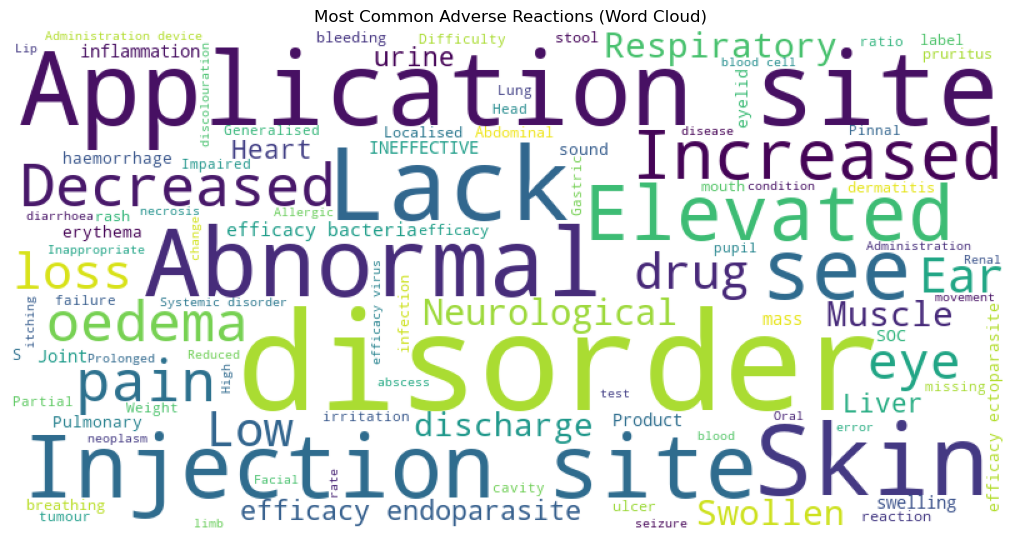


--- Top 10 Most Frequent Terms ---
Site: 100
Disorder: 92
Application: 56
Lack: 55
Skin: 52
Efficacy: 51
Abnormal: 48
Injection: 43
See: 38
Elevated: 31


In [80]:
# Phase 4 (Bonus): Text Analytics

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
import sqlite3

# Connect to Database
# Ensure DB_PATH is defined (it should be from previous cells)
if 'DB_PATH' not in locals():
    DB_PATH = '../data/veterinary_dw.db'

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# 1. Fetch Unstructured Text Data
print("Fetching reaction descriptions for Text Analytics...")
try:
    cursor.execute("SELECT ReactionName FROM DimReaction")
    reactions = cursor.fetchall()
except sqlite3.OperationalError:
    print("⚠️ Error: DimReaction table not found. Please run the ETL pipeline (Cells 9-11) first.")
    reactions = []
finally:
    conn.close()

# Flatten list of tuples to a single string
text_data = " ".join([str(r[0]) for r in reactions if r[0]])

if not reactions or not text_data.strip():
    print("⚠️ No reaction data found to analyze.")
    print("Please ensure you have run the 'Load' steps (Cells 10 & 11) to populate the database.")
else:
    # 2. Tokenization and Cleaning
    # Use standard stopwords + domain specific ones (like 'nos' = Not Otherwise Specified)
    stop_words = set(STOPWORDS)
    stop_words.update(["nos", "specified", "unknown", "animal", "veterinary", "clinical"])

    # Pre-check for valid words to give better feedback
    words = re.findall(r'\w+', text_data.lower())
    filtered_words = [w for w in words if w not in stop_words and len(w) > 2]

    if not filtered_words:
        print(f"⚠️ No valid words found for Word Cloud after filtering stop words.")
        print(f"Raw text data sample: {text_data[:100]!r}")
        print("Please run the ETL pipeline (Cells 10 & 11) to populate the database with real data.")
    else:
        # Generate Word Cloud
        print(f"Generating Word Cloud from {len(reactions)} unique reactions...")

        try:
            wordcloud = WordCloud(width=800, height=400,
                                background_color='white',
                                stopwords=stop_words,
                                min_font_size=10).generate(text_data)

            # 3. Display Visualization
            plt.figure(figsize=(10, 5), facecolor=None)
            # FIX: Use .to_image() to avoid numpy compatibility issue
            plt.imshow(wordcloud.to_image())
            plt.axis("off")
            plt.tight_layout(pad=0)
            plt.title("Most Common Adverse Reactions (Word Cloud)")
            plt.show()

            # 4. Frequency Analysis
            word_counts = Counter(filtered_words)

            print("\n--- Top 10 Most Frequent Terms ---")
            for word, count in word_counts.most_common(10):
                print(f"{word.title()}: {count}")

        except ValueError as e:
            print(f"⚠️ Word Cloud Error: {e}")